In [13]:
!pip -q install yfinance statsmodels

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

plt.rcParams["figure.figsize"] = (12, 6)


In [14]:
ticker = "SPY"   # change to "AAPL" if you want
start  = "2015-01-01"

df = yf.download(ticker, start=start, progress=False)



/tmp/ipython-input-1680663521.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, progress=False)


In [15]:
df.head()

Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2015-01-02,171.093689,172.301341,170.052618,171.884913,121465900
2015-01-05,168.003815,170.210879,167.695662,170.044311,169632600
2015-01-06,166.421402,168.836681,165.621854,168.311977,209151400
2015-01-07,168.495178,168.836652,167.304200,167.753937,125346700
2015-01-08,171.485123,171.701673,169.894377,169.911025,147217800


In [16]:
df = yf.download(ticker, start=start, progress=False)

price_col = "Adj Close" if "Adj Close" in df.columns else "Close"

df = (
    df[[price_col]]
    .rename(columns={price_col: "price"})
    .dropna()
)

df.head()


/tmp/ipython-input-490716271.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, progress=False)


Price,price
Ticker,SPY
Date,
2015-01-02,171.093689
2015-01-05,168.003784
2015-01-06,166.421371
2015-01-07,168.495224
2015-01-08,171.485123


In [17]:
df["log_return"] = np.log(df["price"]).diff()
df.dropna(inplace=True)

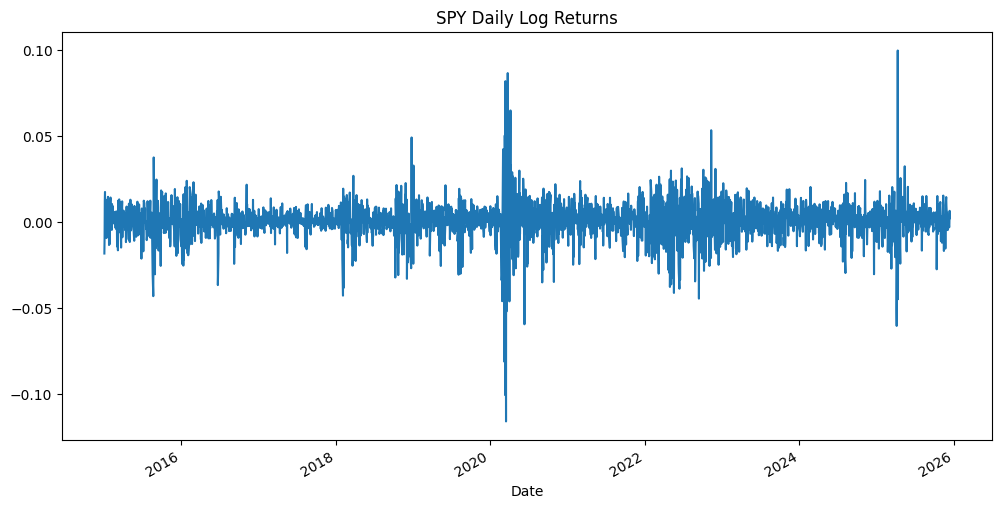

In [18]:
df["log_return"].plot(title=f"{ticker} Daily Log Returns")
plt.show()

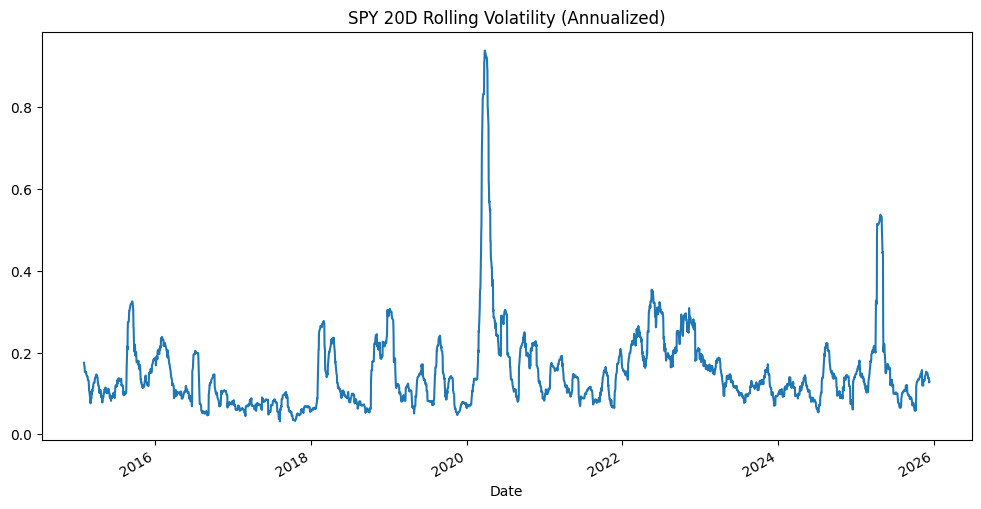

In [19]:
window = 20  # ~1 trading month
trading_days = 252

df["vol_20d_ann"] = df["log_return"].rolling(window).std() * np.sqrt(trading_days)

df["vol_20d_ann"].plot(title=f"{ticker} 20D Rolling Volatility (Annualized)")
plt.show()

In [20]:
short_w = 50
long_w  = 200

df["ma_short"] = df["price"].rolling(short_w).mean()
df["ma_long"]  = df["price"].rolling(long_w).mean()

# Signal: 1 when short MA > long MA, else 0
df["signal"] = (df["ma_short"] > df["ma_long"]).astype(int)

# Positions (when the signal changes)
df["position_change"] = df["signal"].diff()


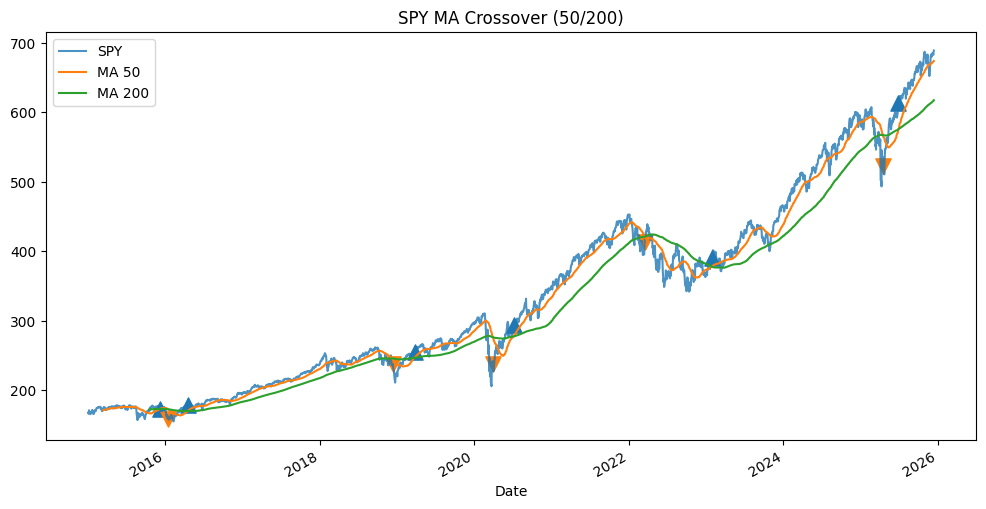

In [21]:
ax = df["price"].plot(label="Price", alpha=0.8, title=f"{ticker} MA Crossover ({short_w}/{long_w})")
df["ma_short"].plot(ax=ax, label=f"MA {short_w}")
df["ma_long"].plot(ax=ax, label=f"MA {long_w}")

buy = df[df["position_change"] == 1]
sell = df[df["position_change"] == -1]
plt.scatter(buy.index, buy["price"], marker="^", s=120)
plt.scatter(sell.index, sell["price"], marker="v", s=120)

plt.legend()
plt.show()


In [22]:
def adf_test(series, name="series"):
    series = series.dropna()
    stat, pval, *_ = adfuller(series)
    print(f"ADF test on {name}: statistic={stat:.4f}, p-value={pval:.4g}")

adf_test(df["price"], "price")
adf_test(df["log_return"], "log_return")

ADF test on price: statistic=1.2080, p-value=0.996
ADF test on log_return: statistic=-16.9859, p-value=8.942e-30


In [23]:
y = df["log_return"].dropna()

train_size = int(len(y) * 0.8)
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

y_train.index.min(), y_train.index.max(), y_test.index.min(), y_test.index.max()


(Timestamp('2015-01-05 00:00:00'),
 Timestamp('2023-10-02 00:00:00'),
 Timestamp('2023-10-03 00:00:00'),
 Timestamp('2025-12-11 00:00:00'))

In [24]:
arima_order = (1, 0, 1)

arima_model = ARIMA(y_train, order=arima_order).fit()
print(arima_model.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             log_return   No. Observations:                 2201
Model:                 ARIMA(1, 0, 1)   Log Likelihood                6720.490
Date:                Fri, 12 Dec 2025   AIC                         -13432.981
Time:                        04:32:26   BIC                         -13410.194
Sample:                             0   HQIC                        -13424.654
                               - 2201                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      1.687      0.092   -6.49e-05       0.001
ar.L1         -0.4760      0.050     -9.595      0.000      -0.573      -0.379
ma.L1          0.3541      0.054      6.613      0.0

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


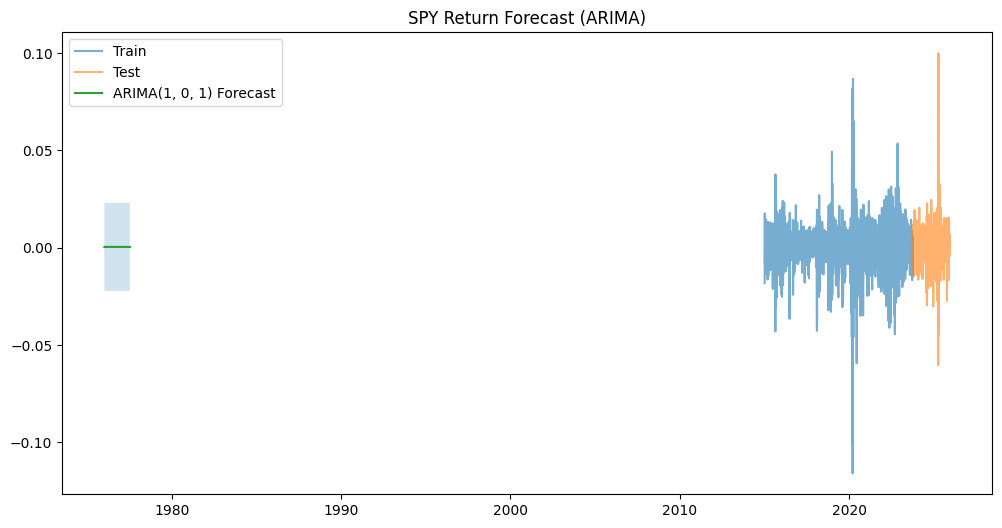

In [25]:
h = len(y_test)
arima_fc = arima_model.get_forecast(steps=h)
arima_mean = arima_fc.predicted_mean
arima_ci = arima_fc.conf_int()

plt.plot(y_train.index, y_train, label="Train", alpha=0.6)
plt.plot(y_test.index, y_test, label="Test", alpha=0.6)
plt.plot(arima_mean.index, arima_mean, label=f"ARIMA{arima_order} Forecast")
plt.fill_between(arima_ci.index, arima_ci.iloc[:,0], arima_ci.iloc[:,1], alpha=0.2)
plt.title(f"{ticker} Return Forecast (ARIMA)")
plt.legend()
plt.show()


In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, arima_mean)
rmse = np.sqrt(mean_squared_error(y_test, arima_mean))
print("ARIMA MAE:", mae)
print("ARIMA RMSE:", rmse)


ARIMA MAE: 0.006570612803607641
ARIMA RMSE: 0.010073725491254435


In [27]:
sarima_order = (1, 0, 1)
seasonal_order = (1, 0, 1, 5)  # (P,D,Q,s)

sarima_model = SARIMAX(
    y_train,
    order=sarima_order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

print(sarima_model.summary())


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                        log_return   No. Observations:                 2201
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 5)   Log Likelihood                6697.286
Date:                           Fri, 12 Dec 2025   AIC                         -13384.572
Time:                                   04:36:09   BIC                         -13356.104
Sample:                                        0   HQIC                        -13374.168
                                          - 2201                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4799      0.052     -9.268      0.000      -0.581      -0.378
ma.L1          0.3595      0.055      6.494

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


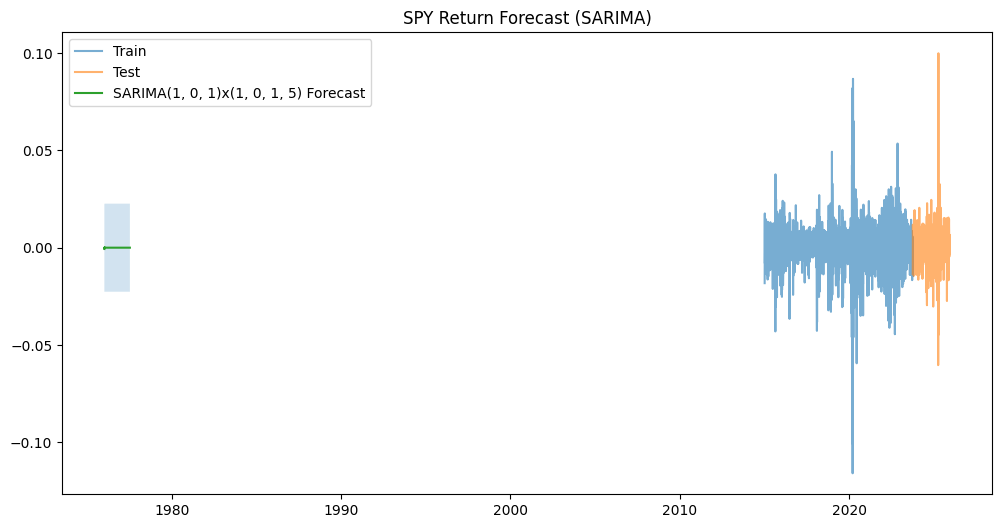

In [28]:
sarima_fc = sarima_model.get_forecast(steps=h)
sarima_mean = sarima_fc.predicted_mean
sarima_ci = sarima_fc.conf_int()

plt.plot(y_train.index, y_train, label="Train", alpha=0.6)
plt.plot(y_test.index, y_test, label="Test", alpha=0.6)
plt.plot(sarima_mean.index, sarima_mean, label=f"SARIMA{sarima_order}x{seasonal_order} Forecast")
plt.fill_between(sarima_ci.index, sarima_ci.iloc[:,0], sarima_ci.iloc[:,1], alpha=0.2)
plt.title(f"{ticker} Return Forecast (SARIMA)")
plt.legend()
plt.show()


In [29]:
mae = mean_absolute_error(y_test, sarima_mean)
rmse = np.sqrt(mean_squared_error(y_test, sarima_mean))
print("SARIMA MAE:", mae)
print("SARIMA RMSE:", rmse)

SARIMA MAE: 0.006633640263975605
SARIMA RMSE: 0.010101090018591725


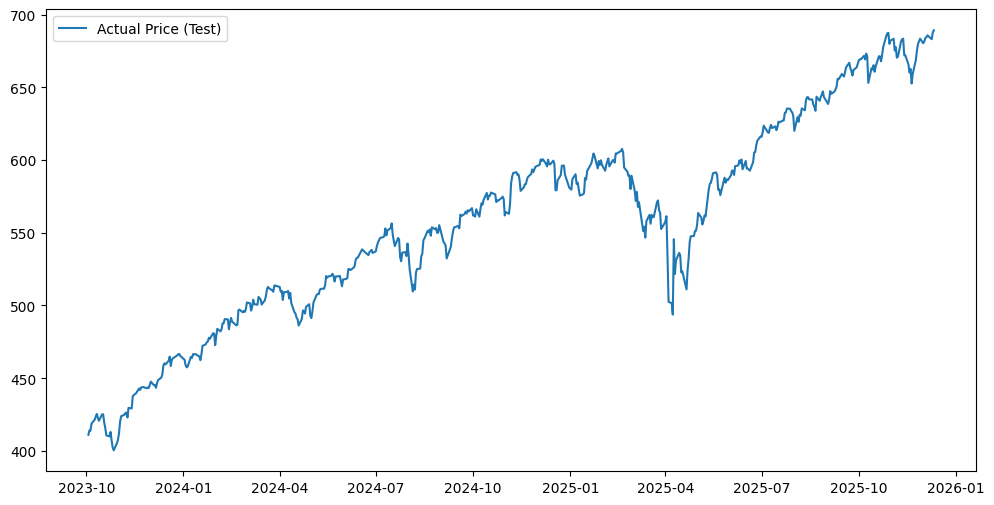

In [31]:
last_train_price = df.loc[y_train.index.max(), "price"]

# pick which forecast to use:
fc_returns = sarima_mean  # or arima_mean

# build forecast price series
fc_log_price = np.log(last_train_price) + fc_returns.cumsum()
fc_price = np.exp(fc_log_price)

# build an "actual" price series for comparison over test window
actual_price_test = df.loc[y_test.index, "price"]

plt.plot(actual_price_test.index, actual_price_test, label="Actual Price (Test)")

plt.legend()
plt.show()
